In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima.arima import auto_arima

import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('Metro_zori_uc_sfrcondomfr_sm_month(1).CSV')
data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
0,102001,0,United States,country,NaN,1204.964064,1211.523337,1220.539083,1229.631503,1238.971442,...,1974.484122,1984.038303,1988.713282,1989.992642,1986.229219,1983.095297,1979.579221,1984.061547,1992.382332,2005.108941
1,394913,1,"New York, NY",msa,NY,2274.903988,2289.780685,2308.292159,2328.700819,2343.991452,...,3270.656162,3288.406598,3293.793228,3283.167886,3268.389133,3256.816076,3250.841738,3261.024948,3281.796807,3313.331883
2,753899,2,"Los Angeles, CA",msa,CA,1807.141280,1819.683413,1836.319303,1850.460938,1864.975841,...,2917.827829,2932.130095,2938.162398,2942.386297,2939.386912,2935.736684,2928.205711,2950.268103,2972.333872,2997.269136
3,394463,3,"Chicago, IL",msa,IL,1429.049735,1435.936653,1445.858633,1455.233797,1465.724849,...,2080.783276,2090.849551,2094.402214,2092.927997,2091.194710,2092.516081,2096.305554,2103.605019,2119.863071,2138.626729
4,394514,4,"Dallas, TX",msa,TX,1109.399485,1114.367197,1122.200307,1134.267945,1144.231583,...,1774.230617,1781.419709,1784.736695,1781.088672,1773.851017,1765.211269,1758.119108,1756.314712,1762.101968,1773.313924


In [3]:



# ناخد الأعمدة من RegionName ولحد آخر عمود تاريخ
date_cols = data.columns[data.columns.get_loc("2015-01-31"):]
data_subset = data[["RegionName"] + list(date_cols)]

# نحول الأعمدة الزمنية إلى صفوف
melted = data_subset.melt(id_vars="RegionName", var_name="date", value_name="value")
melted["date"] = pd.to_datetime(melted["date"])

# نعمل pivot علشان كل مدينة تبقى عمود
allts = melted.pivot(index="date", columns="RegionName", values="value")
# timeseries = allts.pivot(index="date", columns="RegionName", values="value")
timeseries=allts.dropna(axis=1)
# نطبع أول شوية بيانات
timeseries.to_csv('timeseries.csv')


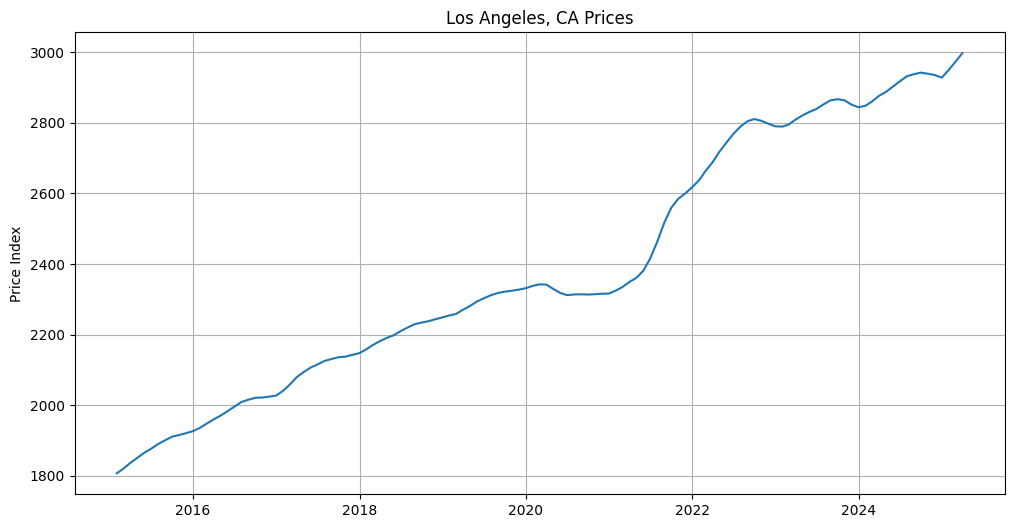

In [4]:
# Example: load from a CSV with a datetime index
tsname='Los Angeles, CA'
ts = timeseries[tsname]

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title(f'{ts.name} Prices')
plt.ylabel('Price Index')
plt.grid(True)
plt.show()


Training data size: 98
Testing data size: 25


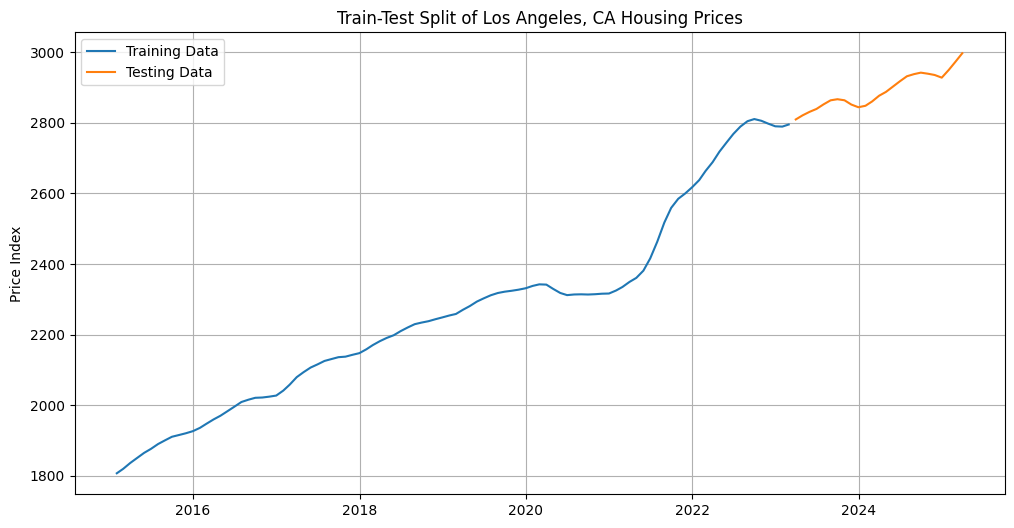

In [5]:
# Split data into train and test sets
train_size = int(len(ts) * 0.8)
ts_train, ts_test = ts[:train_size], ts[train_size:]

print(f"Training data size: {len(ts_train)}")
print(f"Testing data size: {len(ts_test)}")

# Plot the training and testing data
plt.figure(figsize=(12, 6))
plt.plot(ts_train, label='Training Data')
plt.plot(ts_test, label='Testing Data')
plt.title(f'Train-Test Split of {tsname} Housing Prices')
plt.ylabel('Price Index')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def check_stationarity(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.dropna())
    print(f'Adata Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    # Interpret the results
    if result[1] <= 0.05:
        print("\nData is stationary (reject null hypothesis)")
    else:
        print("\nData is non-stationary (fail to reject null hypothesis)")

# Check stationarity of original series
print("Stationarity check of original series:")
check_stationarity(ts_train)

Stationarity check of original series:
Adata Statistic: 0.42667567671188944
p-value: 0.9824655689636465
Critical Values:
	1%: -3.5097356063504983
	5%: -2.8961947486260944
	10%: -2.5852576124567475

Data is non-stationary (fail to reject null hypothesis)


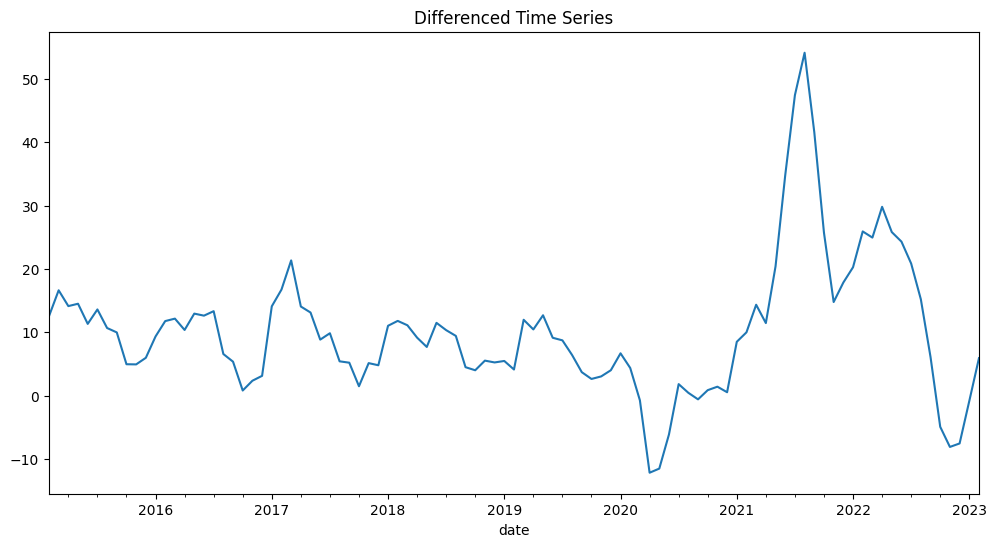

Adata Statistic: -3.3536719465177796
p-value: 0.01264329598791922
Critical Values:
	1%: -3.5097356063504983
	5%: -2.8961947486260944
	10%: -2.5852576124567475

Data is stationary (reject null hypothesis)


In [7]:
ts_diff = ts_train.diff().dropna()  # First difference
ts_diff.plot(figsize=(12, 6), title="Differenced Time Series")
plt.show()
check_stationarity(ts_diff)


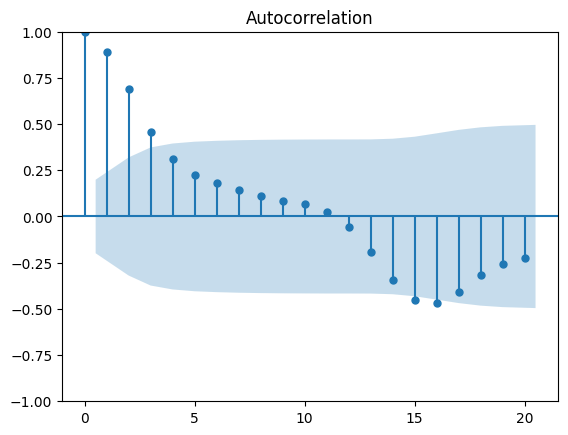

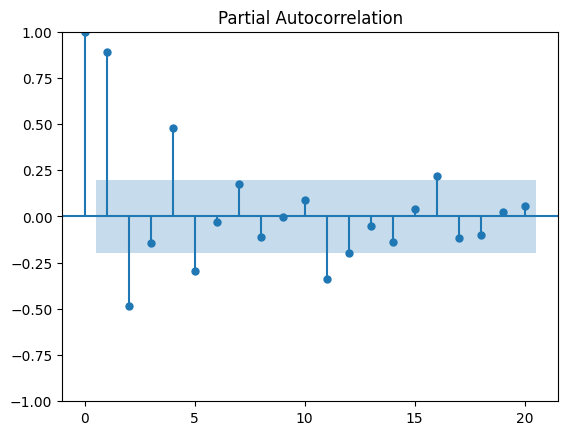

In [8]:
plot_acf(ts_diff)
plot_pacf(ts_diff)
plt.show()


In [9]:
model = ARIMA(ts_train, order=(2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:        Los Angeles, CA   No. Observations:                   98
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -284.131
Date:                Fri, 02 May 2025   AIC                            574.262
Time:                        16:46:02   BIC                            581.986
Sample:                    01-31-2015   HQIC                           577.385
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3473      0.073     18.571      0.000       1.205       1.489
ar.L2         -0.4340      0.077     -5.616      0.000      -0.585      -0.283
sigma2        19.9742      2.749      7.266      0.0

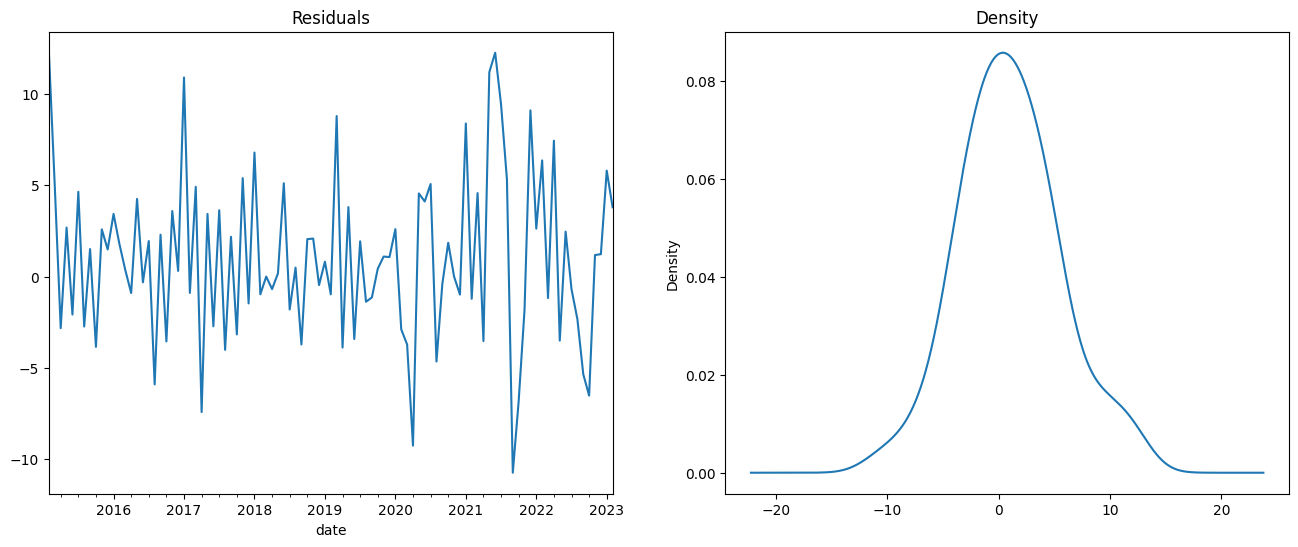

In [10]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(16, 6))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

<Axes: xlabel='date'>

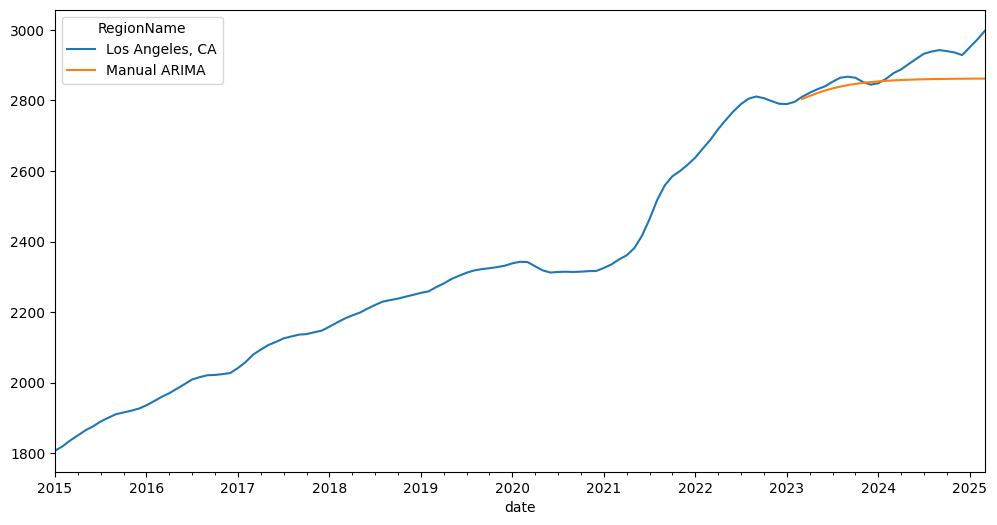

In [11]:
forecast_test = model_fit.forecast(len(ts_test))
timeseries['Manual ARIMA'] = [None]*len(ts_train) + list(forecast_test)
timeseries[[tsname, 'Manual ARIMA']].plot(figsize=(12,6))

In [12]:
amodel=auto_arima(ts_train,start_p=0,d=1,start_q=0,
        max_p=5,max_d=5,max_q=5, start_P=0,
        D=1, start_Q=0, max_P=5,max_D=5,
        max_Q=5, m=12, seasonal=[False],
        error_action='warn',trace=True,
        supress_warnings=True,stepwise=True,
        random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=711.685, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=531.934, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=551.451, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=526.036, Time=0.41 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=527.209, Time=0.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=680.191, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=509.678, Time=0.19 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=513.851, Time=0.09 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=508.481, Time=0.86 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=510.208, Time=1.39 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=509.23

In [13]:
print(amodel.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   98
Model:             SARIMAX(3, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -246.928
Date:                              Fri, 02 May 2025   AIC                            503.856
Time:                                      16:46:33   BIC                            516.069
Sample:                                  01-31-2015   HQIC                           508.768
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2293      0.087     14.106      0.000       1.058       1.400
ar.L2         -0.18

<Axes: xlabel='date'>

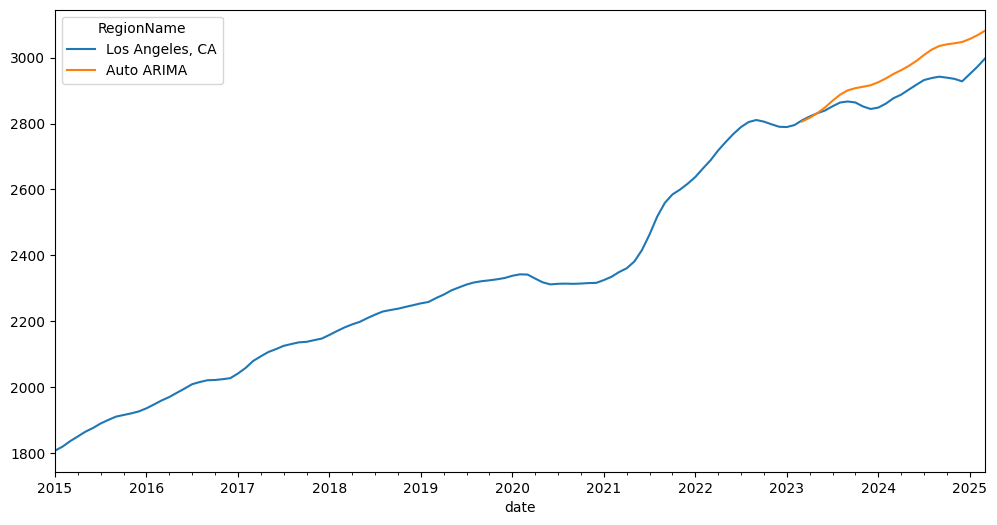

In [14]:
aforecast_test = amodel.predict(len(ts_test))
timeseries['Auto ARIMA'] = [None]*len(ts_train) + list(aforecast_test)
timeseries[[tsname,'Auto ARIMA']].plot(figsize=(12,6))

In [17]:
results = {}


manual_rmse = np.sqrt(mean_squared_error(ts_test, forecast_test))
manual_mae = mean_absolute_error(ts_test, forecast_test)
manual_r2 = r2_score(ts_test, forecast_test)

results['Manual ARIMA'] = {
    'RMSE': manual_rmse,
    'MAE': manual_mae,
    'R²': manual_r2
}

auto_rmse = np.sqrt(mean_squared_error(ts_test, aforecast_test))
auto_mae = mean_absolute_error(ts_test, aforecast_test)
auto_r2 = r2_score(ts_test, aforecast_test)

results['Auto ARIMA'] = {
    'RMSE': auto_rmse,
    'MAE': auto_mae,
    'R²': auto_r2
}

for model, values in results.items():
        print(f"{model}: RMSE= {values['RMSE']:.2f}, MAE= {values['MAE']:.2f}, R²= {values['R²']:.2f}")


Manual ARIMA: RMSE= 57.28, MAE= 43.44, R²= -0.32
Auto ARIMA: RMSE= 72.53, MAE= 63.30, R²= -1.11


: 